**This notebook extends the single basin prediction work to multiple basins in Idaho. It uses a file called the gauge_information file to access and identify the basin IDs within Idaho. To ensure proper integration, I had to carefully format and refine the gauge information files. Meteorological data is then loaded based on Idaho's geographical boundaries, using its longitude and latitude. The LSTM model is applied to predict discharge across these basins. Finally, the notebook evaluates the predictions and assesses the overall performance of the model.**

In [1]:
import sys
from pathlib import Path
#------------ Define the path to the folder containing your scripts
scripts_path = Path("/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/scripts").resolve()
#------------ Add this path to sys.path if it's not already included
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))
    
from train import*
from data_processing import*
from model import Model
from data_loader import*
from packages import*
from numpy import random

# 1) Predicting Multiple Basins

In [2]:
# --------------------- Extract Basin IDs ---------------------
def extract_gage_ids(file_path):
    df = pd.read_excel(file_path)
    # Extract last word from GAUGE_NAME and match 'ID'
    last_word = df['GAUGE_NAME'].str.extract(r'\s*(\w+)$')[0].str.upper()
    matches = df[last_word == 'ID']
    return matches['GAGE_ID'].astype(str).tolist()

gage_info_path = '/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/data/gauge_information.xlsx'
all_basin_ids = extract_gage_ids(gage_info_path)
print("All basin IDs:", all_basin_ids)

# Randomly select one basin as the transfer (held-out) target.
test_basin = random.choice(all_basin_ids)
# Use all other basins for multi-basin training.
train_basin_ids = [bid for bid in all_basin_ids if bid != test_basin]
print(f"Transfer learning target (held-out basin): {test_basin}")
print(f"Training on {len(train_basin_ids)} basins.")

All basin IDs: ['12411000', '12414500', '13083000', '13235000', '13240000', '13310700', '13313000', '13337000', '13338500', '13340000', '13340600']
Transfer learning target (held-out basin): 13340600
Training on 10 basins.


In [3]:
# --------------------------- Configuration Parameters ---------------------------
hidden_size = 10              # Number of LSTM cells in the model
dropout_rate = 0.0            # Dropout rate for the final fully connected layer
learning_rate = 1e-3          # Learning rate for the optimizer
sequence_length = 365         # Length (in days) of the meteorological record for each sample

# --------------------------- Dataset Setup for Training (Multi-Basin) ---------------------------
# Define date ranges for each dataset partition (adjust as needed)
train_start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
train_end_date   = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
val_start_date   = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
val_end_date     = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
test_start_date  = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date    = pd.to_datetime("2010-09-30", format="%Y-%m-%d")

# Load and combine training datasets from all training basins.
train_x_list = []
train_y_list = []
val_x_list = []
val_y_list = []
test_x_list = []
test_y_list = []

print("Loading multi-basin training data ...")
for bid in train_basin_ids:
    # Training data
    ds_train = CamelsTXT(bid, seq_length=sequence_length, period="train", dates=[train_start_date, train_end_date])
    # For simplicity, we assume ds_train.x and ds_train.y are torch.Tensors.
    train_x_list.append(ds_train.x)
    train_y_list.append(ds_train.y)
    # Validation data
    ds_val = CamelsTXT(bid, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                      means=ds_train.get_means(), stds=ds_train.get_stds())
    val_x_list.append(ds_val.x)
    val_y_list.append(ds_val.y)
    # Test data (if needed for internal evaluation)
    ds_test = CamelsTXT(bid, seq_length=sequence_length, period="eval", dates=[test_start_date, test_end_date],
                       means=ds_train.get_means(), stds=ds_train.get_stds())
    test_x_list.append(ds_test.x)
    test_y_list.append(ds_test.y)

# Concatenate data from all basins along the sample dimension
train_x_combined = torch.cat(train_x_list, dim=0)
train_y_combined = torch.cat(train_y_list, dim=0)
val_x_combined   = torch.cat(val_x_list, dim=0)
val_y_combined   = torch.cat(val_y_list, dim=0)

print(f"Combined training samples: {train_x_combined.size(0)}")
print(f"Combined validation samples: {val_x_combined.size(0)}")

# Create DataLoaders for multi-basin training
tr_loader = DataLoader(TensorDataset(train_x_combined, train_y_combined), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(val_x_combined, val_y_combined), batch_size=2048, shuffle=False)

# --------------------------- Load Data for Held-Out Basin (Transfer Learning) ---------------------------
# For the held-out basin, we load its evaluation (transfer) data separately.
ds_transfer = CamelsTXT(test_basin, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                        means=ds_train.get_means(), stds=ds_train.get_stds())
transfer_loader = DataLoader(ds_transfer, batch_size=2048, shuffle=False)

Loading multi-basin training data ...
Combined training samples: 49373
Combined validation samples: 18280


In [4]:
# --------------------------- Model, Optimizer, and Loss Setup ---------------------------
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

# --------------------------- Summary and Debug Information ---------------------------
print("Configuration:")
print(f" Training on basins: {train_basin_ids}")
print(f" Transfer target basin: {test_basin}")
print(f" Sequence length: {sequence_length}")
print(f" Hidden size: {hidden_size}")
print(f" Dropout rate: {dropout_rate}")
print(f" Learning rate: {learning_rate}")
print(f" Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f" Validation period: {val_start_date.date()} to {val_end_date.date()}")
print(f" Test period: {test_start_date.date()} to {test_end_date.date()}")
print("\nModel summary:")
print(model)

Configuration:
 Training on basins: ['12411000', '12414500', '13083000', '13235000', '13240000', '13310700', '13313000', '13337000', '13338500', '13340000']
 Transfer target basin: 13340600
 Sequence length: 365
 Hidden size: 10
 Dropout rate: 0.0
 Learning rate: 0.001
 Training period: 1980-10-01 to 1995-09-30
 Validation period: 1995-10-01 to 2000-09-30
 Test period: 2000-10-01 to 2010-09-30

Model summary:
Model(
  (lstm): LSTM(5, 10, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [5]:
# --------------------------- Training Loop ---------------------------
n_epochs = 20
train_loss_list = []
val_loss_list = []
val_nse_list = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for xs, ys in tr_loader:
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        optimizer.zero_grad()
        predictions = model(xs)
        loss = loss_func(predictions, ys)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xs.size(0)
    epoch_train_loss = running_train_loss / train_x_combined.size(0)
    train_loss_list.append(epoch_train_loss)
    
    # Validation phase (Loss)
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xs, ys in val_loader:
            xs, ys = xs.to(DEVICE), ys.to(DEVICE)
            predictions = model(xs)
            loss = loss_func(predictions, ys)
            running_val_loss += loss.item() * xs.size(0)
    epoch_val_loss = running_val_loss / val_x_combined.size(0)
    val_loss_list.append(epoch_val_loss)
    
    # Validation phase (NSE)
    obs, preds = eval_model(model, val_loader)
    preds = ds_transfer.local_rescale(preds.numpy(), variable='output')  # use transfer basin normalization
    nse = calc_nse(obs.numpy(), preds)
    val_nse_list.append(nse)
    
    tqdm.tqdm.write(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Validation NSE: {nse:.2f}")


python(59961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1/20 - Train Loss: 0.6479 - Validation NSE: 0.29
Epoch 2/20 - Train Loss: 0.3895 - Validation NSE: 0.32
Epoch 3/20 - Train Loss: 0.3523 - Validation NSE: 0.34
Epoch 4/20 - Train Loss: 0.3223 - Validation NSE: 0.36
Epoch 5/20 - Train Loss: 0.3050 - Validation NSE: 0.36
Epoch 6/20 - Train Loss: 0.2948 - Validation NSE: 0.35
Epoch 7/20 - Train Loss: 0.2855 - Validation NSE: 0.37
Epoch 8/20 - Train Loss: 0.2783 - Validation NSE: 0.34
Epoch 9/20 - Train Loss: 0.2707 - Validation NSE: 0.35
Epoch 10/20 - Train Loss: 0.2611 - Validation NSE: 0.37
Epoch 11/20 - Train Loss: 0.2511 - Validation NSE: 0.38
Epoch 12/20 - Train Loss: 0.2436 - Validation NSE: 0.37
Epoch 13/20 - Train Loss: 0.2365 - Validation NSE: 0.38
Epoch 14/20 - Train Loss: 0.2357 - Validation NSE: 0.38
Epoch 15/20 - Train Loss: 0.2265 - Validation NSE: 0.38
Epoch 16/20 - Train Loss: 0.2186 - Validation NSE: 0.38
Epoch 17/20 - Train Loss: 0.2121 - Validation NSE: 0.38
Epoch 18/20 - Train Loss: 0.2098 - Validation NSE: 0.38
E

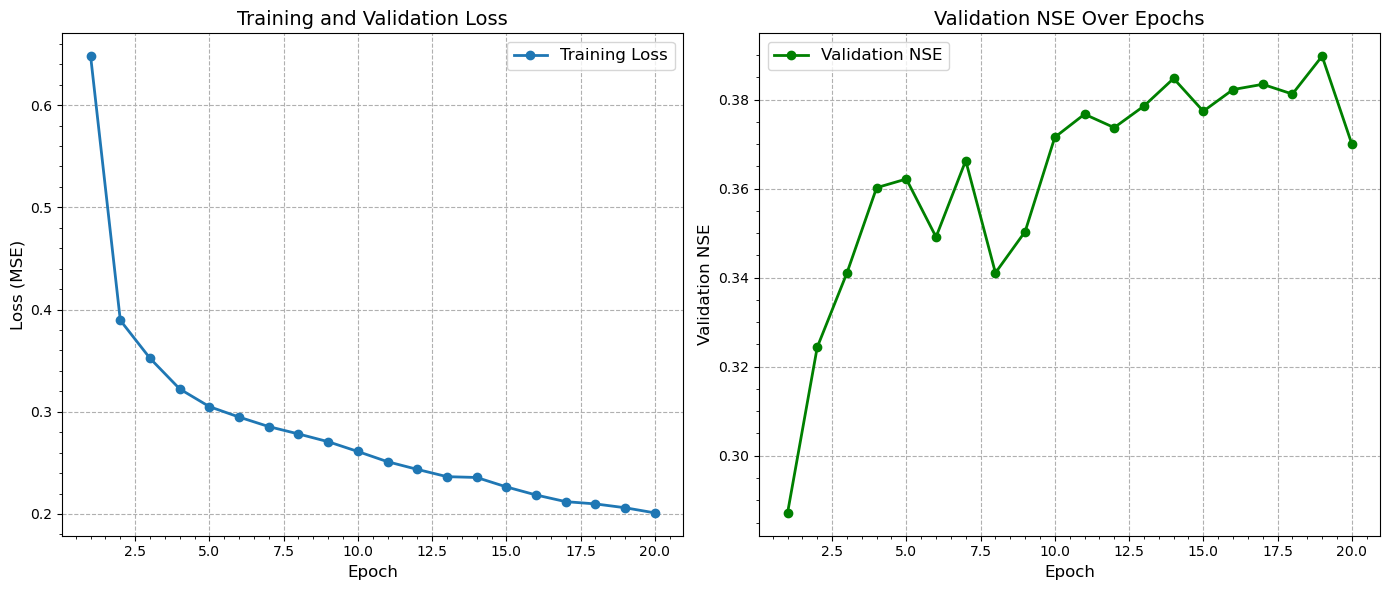

In [6]:
# Assuming epochs, train_loss_list, val_loss_list, and val_nse_list are defined:
epochs = range(1, n_epochs + 1)

# Create one figure with two subplots side by side
plt.figure(figsize=(14, 6))

# ---------------------------
# Training and Validation Loss
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label="Training Loss", marker='o', linewidth=2)
# plt.plot(epochs, val_loss_list, label="Validation Loss", marker='o', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()

# ---------------------------
# Validation NSE
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_nse_list, label="Validation NSE", marker='o', linewidth=2, color='green')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation NSE", fontsize=12)
plt.title("Validation NSE Over Epochs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()
plt.tight_layout()
plt.show()

The MSE steadily decreases, meaning the model is learning to fit the training data over time. However, the Validation NSE fluctuates instead of steadily improving, suggesting the model’s performance on unseen data is somewhat inconsistent. 

In [7]:
# --------------------------- Save the Global Multi-Basin Model ---------------------------
model_path = "/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/multiple_basins"
model_save_path = model_path + "/multiple_model_weights.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Global multi-basin model saved as '{model_save_path}'.")

Global multi-basin model saved as '/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/multiple_basins/multiple_model_weights.pth'.


In [8]:
# Define test date range (adjust as needed)
test_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date   = pd.to_datetime("2010-09-30", format="%Y-%m-%d")

# Loop over each basin in the training set (predicted basins)
for bid in train_basin_ids:  # train_basin_ids was defined earlier as the list of basins used for training
    # Create a test dataset for the current basin using the same normalization from training
    ds_test_i = CamelsTXT(bid, seq_length=sequence_length, period="eval",
                          dates=[test_start_date, test_end_date],
                          means=means, stds=stds)
    test_loader_i = DataLoader(ds_test_i, batch_size=2048, shuffle=False)
    
    # Evaluate the model on the test set for this basin
    obs, preds = eval_model(model, test_loader_i)
    preds = ds_test_i.local_rescale(preds.numpy(), variable='output')
    obs = obs.numpy()
    nse = calc_nse(obs, preds)
    
    # Create a date range from the dataset's dates (assumes ds_test_i.dates is defined as [start_date, end_date])
    start_date = ds_test_i.dates[0]
    end_date = ds_test_i.dates[1] + pd.DateOffset(days=1)
    date_range = pd.date_range(start_date, end_date)
    
    # Plot the observed vs. predicted time series for this basin
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_range, obs, label="Observation", lw=2, color="blue")
    ax.plot(date_range, preds, label="Prediction", lw=2, color="red")
    ax.set_title(f"Basin {bid} - Test set NSE: {nse:.3f}", fontsize=14, loc="left")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Discharge (mm/d)", fontsize=12)
    ax.legend(fontsize=12)
    ax.tick_params(axis='x')
    ax.minorticks_on()
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()


NameError: name 'means' is not defined

In [ ]:
# List of basins to plot (for example, all training basins)
basins_to_plot = train_basin_ids  # defined earlier; list of basin IDs (strings)
n_basins = len(basins_to_plot)

# Determine grid size (rows x columns)
n_cols = math.ceil(math.sqrt(n_basins))
n_rows = math.ceil(n_basins / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()  # flatten to a 1D list for easy iteration

for i, bid in enumerate(basins_to_plot):
    # Create test dataset for current basin
    ds_test_i = CamelsTXT(bid, seq_length=sequence_length, period="eval",
                          dates=[test_start_date, test_end_date],
                          means=means, stds=stds)
    test_loader_i = DataLoader(ds_test_i, batch_size=2048, shuffle=False)
    
    # Evaluate the model on the test set for this basin
    obs, preds = eval_model(model, test_loader_i)
    preds = ds_test_i.local_rescale(preds.numpy(), variable='output')
    obs = obs.numpy()
    
    # Calculate performance metrics
    r2 = r2_score(obs, preds)
    mse = mean_squared_error(obs, preds)
    mae = mean_absolute_error(obs, preds)
    
    # Plot scatter plot on the corresponding axis
    ax = axes[i]
    ax.scatter(obs, preds, alpha=0.7, edgecolor='k')
    # Plot a 1:1 reference line
    min_val = np.min([obs.min(), preds.min()])
    max_val = np.max([obs.max(), preds.max()])
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    # Set labels and title (with metrics)
    ax.set_xlabel("Observed (mm/d)", fontsize=10)
    ax.set_ylabel("Predicted (mm/d)", fontsize=10)
    ax.set_title(f"Basin {bid}\n$R^2$ = {r2:.3f}\nMSE = {mse:.3f}, MAE = {mae:.3f}", fontsize=10)
    ax.minorticks_on()
    ax.grid(True, linestyle='--')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Select basins to plot (for example, using the training basins)
basins_to_plot = train_basin_ids
n_basins = len(basins_to_plot)

# Determine grid size
n_cols = math.ceil(math.sqrt(n_basins))
n_rows = math.ceil(n_basins / n_cols)

# Create figure and axes grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, bid in enumerate(basins_to_plot):
    # Create a test dataset for the current basin
    ds_test_i = CamelsTXT(bid, seq_length=sequence_length, period="eval",
                          dates=[test_start_date, test_end_date],
                          means=means, stds=stds)
    test_loader_i = DataLoader(ds_test_i, batch_size=2048, shuffle=False)
    
    # Evaluate the model on the test set
    obs, preds = eval_model(model, test_loader_i)
    preds = ds_test_i.local_rescale(preds.numpy(), variable='output')
    obs = obs.numpy()
    
    # Compute residuals (Prediction - Observation)
    residuals = preds - obs
    
    # Plot histogram on the current subplot
    ax = axes[i]
    ax.hist(residuals, bins=30, color='blue', edgecolor='k', alpha=0.7)
    ax.set_xlabel("Residual (Pred - Obs)", fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Basin {bid}", fontsize=10)
    ax.minorticks_on()
    ax.grid(True, linestyle='--')

# Remove any extra axes if the grid is larger than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 2) Perform Transfer Learning on Another Basin

In [ ]:
# --------------- Transfer Learning on Held-Out Basin ---------------
# Fine-tune the global model on the held-out basin (transfer learning) by running a few additional epochs on ds_transfer.
finetune_epochs = 5
optimizer_ft = optim.Adam(model.parameters(), lr=1e-8)  # Lower learning rate for fine-tuning
model.train()
ft_loss_history = []

for ft_epoch in range(finetune_epochs):
    running_ft_loss = 0.0
    for xs, ys in transfer_loader:
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        optimizer_ft.zero_grad()
        pred = model(xs)
        loss = loss_func(pred, ys)
        loss.backward()
        optimizer_ft.step()
        running_ft_loss += loss.item() * xs.size(0)
    epoch_ft_loss = running_ft_loss / len(ds_transfer)
    ft_loss_history.append(epoch_ft_loss)
    print(f"Fine-tuning Epoch {ft_epoch+1}/{finetune_epochs} - Loss: {epoch_ft_loss:.4f}")

# Plot the fine-tuning loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, finetune_epochs+1), ft_loss_history, marker='o', linestyle='-', color='purple')
plt.xlabel("Fine-Tuning Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Fine-Tuning Loss on Held-Out Basin")
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

# Save the fine-tuned model for the transfer basin
finetuned_model_save_path = model_path + f"/finetuned_model_{test_basin}.pth"
torch.save(model.state_dict(), finetuned_model_save_path)
print(f"Fine-tuned model for basin {test_basin} saved as '{finetuned_model_save_path}'.")

In [ ]:
# ---------------------------
# Load the Pretrained Model
# ---------------------------
# Create a new model instance with the same architecture and load the saved weights.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
model.load_state_dict(torch.load(finetuned_model_save_path))
model.eval()
print(f"Pretrained model loaded from {finetuned_model_save_path}")